In [ ]:
#Data Extraction and Transformation:

import os
import yaml
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns

# Specify the directory where your YAML files are located
base_path = "F:\DDSAMP2\data"  #actual path 

# Use glob to get a list of all YAML files in the directory (including subdirectories)
yaml_files = glob.glob(os.path.join(base_path, "**/*.yaml"), recursive=True)

# Prepare an empty DataFrame to collect everything
wholedf = pd.DataFrame()

# Loop through each YAML file
for file_name in yaml_files:
    # Construct the full file path by combining base_path and file_name
    full_file_path = os.path.join(base_path, file_name)
    
    # Check if file exists
    if os.path.exists(full_file_path):
        try:
            with open(full_file_path, "r") as file:
                data = yaml.safe_load(file)

            # Ensure data is a list before converting to DataFrame
            if isinstance(data, list):
                df = pd.DataFrame(data)
                wholedf = pd.concat([wholedf, df], ignore_index=True)
            else:
                print(f"Data in {file_name} is not in list format.")

        except Exception as e:
            print(f"Error processing file {full_file_path}: {e}")
    else:
        print(f"File not found: {full_file_path}")

# Now 'wholedf' contains all the data from the YAML files
print(wholedf.head())  # Preview the first few rows of the combined DataFrame

# Check if 'Ticker' column exists in the DataFrame
if "Ticker" in wholedf.columns:
    # Loop through each unique ticker and save a separate CSV file
    for ticker in wholedf["Ticker"].unique():
        df_ticker = wholedf[wholedf["Ticker"] == ticker]
        df_ticker.to_csv(f"{ticker}_data.csv", index=False)  # Save a CSV for each ticker
        print(f"Saved CSV for ticker: {ticker}")
else:
    print("No 'Ticker' column found.")


<>:10: SyntaxWarning: invalid escape sequence '\D'
<>:10: SyntaxWarning: invalid escape sequence '\D'
C:\Users\Satya\AppData\Local\Temp\ipykernel_13060\3681542258.py:10: SyntaxWarning: invalid escape sequence '\D'
  base_path = "F:\DDSAMP2\data"  #actual path


       Ticker    close                 date    high      low    month    open  \
0        SBIN   602.95  2023-10-03 05:30:00   604.9   589.60  2023-10   596.6   
1  BAJFINANCE  7967.60  2023-10-03 05:30:00  7975.5  7755.00  2023-10  7780.8   
2       TITAN  3196.25  2023-10-03 05:30:00  3212.5  3114.40  2023-10  3148.8   
3         ITC   439.75  2023-10-03 05:30:00   442.9   439.25  2023-10   441.0   
4         TCS  3513.85  2023-10-03 05:30:00  3534.2  3480.10  2023-10  3534.2   

     volume  
0  15322196  
1    944555  
2   1007308  
3   7481883  
4   1948148  
Saved CSV for ticker: SBIN
Saved CSV for ticker: BAJFINANCE
Saved CSV for ticker: TITAN
Saved CSV for ticker: ITC
Saved CSV for ticker: TCS
Saved CSV for ticker: LT
Saved CSV for ticker: TATACONSUM
Saved CSV for ticker: RELIANCE
Saved CSV for ticker: HCLTECH
Saved CSV for ticker: JSWSTEEL
Saved CSV for ticker: ULTRACEMCO
Saved CSV for ticker: POWERGRID
Saved CSV for ticker: INFY
Saved CSV for ticker: TRENT
Saved CSV for ticke

Inserting into table: top_10_volatility (10 rows)
Inserting into table: volatility_summary (50 rows)
All volatility CSVs inserted into MySQL.


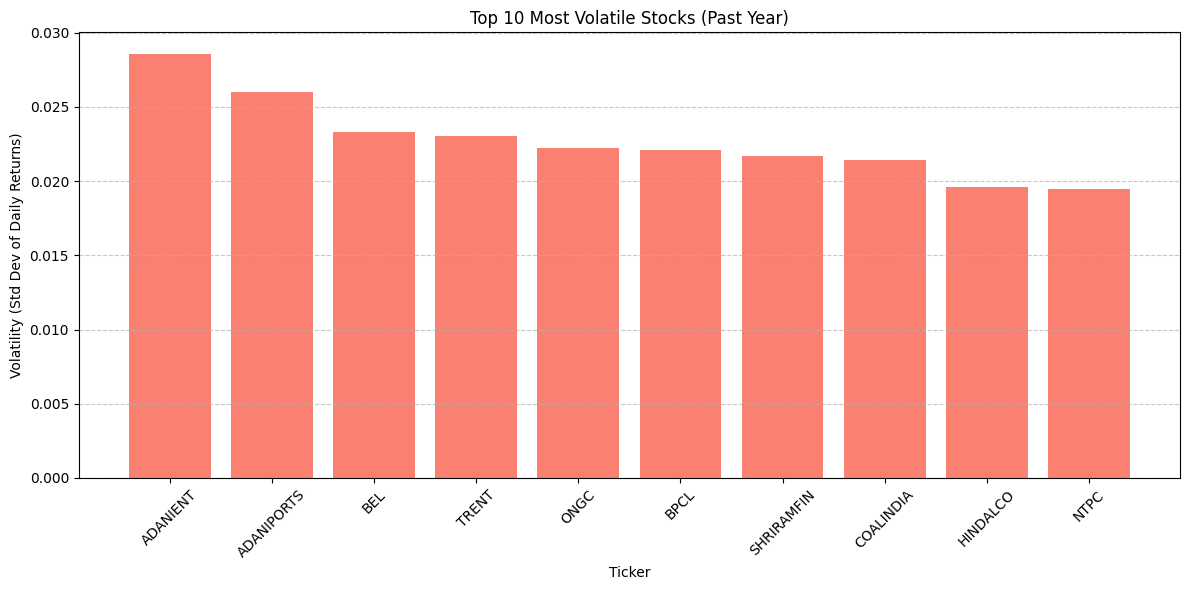

In [4]:
#Data Analysis and Visualization

#1.Volatility Analysis::
       #Objective: Visualize the volatility of each stock over the past year by calculating the standard deviation of daily returns.
       #Reason: Volatility gives insight into how much the price fluctuates, which is valuable for risk assessment. Higher volatility often indicates more risk, while lower volatility indicates a more stable stock.

# === MySQL connection ===
import mysql.connector
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='1q2w3e',
    database='ddsa'
)
cursor = conn.cursor()

# === Folder with all CSV files ===
base_path = r"volatility_csvs"  # Use raw string for Windows paths

# === SQL types for known column names ===
manual_sql_types = {
    "ticker": "VARCHAR(20)",
    "symbol": "VARCHAR(20)",
    "company": "VARCHAR(100)",
    "sector": "VARCHAR(100)",
    "date": "DATE",
    "month": "VARCHAR(10)",
    "open": "FLOAT",
    "high": "FLOAT",
    "low": "FLOAT",
    "close": "FLOAT",
    "volume": "BIGINT",
    "volatility": "FLOAT",
    "monthly_return": "FLOAT"
}


# === Clean column names ===
def clean_column(name):
    return name.strip().replace(" ", "_").replace("-", "_").lower()

# === Create and insert into MySQL ===
def create_and_insert(table_name, df):
    print(f"Inserting into table: {table_name} ({len(df)} rows)")

    # Clean columns
    df.columns = [clean_column(col) for col in df.columns]

    # Convert date columns if they exist
    for col in df.columns:
        if 'date' in col:
            df[col] = pd.to_datetime(df[col], errors='coerce')

    # Drop table if it already exists
    cursor.execute(f"DROP TABLE IF EXISTS `{table_name}`")

    # Build CREATE TABLE statement
    columns_sql = []
    for col in df.columns:
        col_type = manual_sql_types.get(col, "FLOAT")
        columns_sql.append(f"`{col}` {col_type}")
    create_sql = f"CREATE TABLE `{table_name}` ({', '.join(columns_sql)})"
    cursor.execute(create_sql)

    # Insert data row by row
    for _, row in df.iterrows():
        values = ', '.join(
            f"'{str(val).replace('\'', '\'\'')}'" if pd.notna(val) else "NULL"
            for val in row
        )
        insert_sql = f"INSERT INTO `{table_name}` VALUES ({values})"
        try:
            cursor.execute(insert_sql)
        except Exception as e:
            print(f"Insert failed for row: {row.tolist()} — {e}")

    conn.commit()

#  ===volatiliy analysing===

# Path to the folder containing all the input CSVs
data_folder = "nifty_50_data_csvs"  # It's a folder, not a file

# Output folder for processed CSVs
output_folder = "volatility_returns"

# === Load all CSV files from folder ===
for file in os.listdir(base_path):
    if file.endswith(".csv"):
        file_path = os.path.join(base_path, file)

        if not os.access(file_path, os.R_OK):
            print(f"Skipped unreadable file: {file}")
            continue

        try:
            df = pd.read_csv(file_path)
            table_name = os.path.splitext(file)[0].lower()
            create_and_insert(table_name, df)
        except Exception as e:
            print(f"Error processing {file}: {e}")

# === Clean up ===
cursor.close()
conn.close()
print("All volatility CSVs inserted into MySQL.")
os.makedirs(output_folder, exist_ok=True)

# Get all CSV files in that folder
csv_files = glob.glob(os.path.join(data_folder, "*.csv"))

volatility_data = []

for file in csv_files:
    ticker = os.path.basename(file).replace("_data.csv", "")
    
    try:
        df = pd.read_csv(file)

        # Normalize column names
        df.columns = [col.strip().lower().replace(" ", "_") for col in df.columns]

        if 'date' not in df.columns or 'close' not in df.columns:
            print(f"Missing 'date' or 'close' column in {file}")
            continue

        # Parse dates and sort
        df['date'] = pd.to_datetime(df['date'], errors='coerce')
        df = df.dropna(subset=["date"])
        df = df.sort_values("date")

        # Calculate daily return
        df["daily_return"] = df["close"].pct_change()

        # Calculate volatility
        volatility = df["daily_return"].std()

        # Append summary for plotting
        volatility_data.append({"Ticker": ticker, "Volatility": volatility})

        # Save the per-ticker file with returns
        output_path = os.path.join(output_folder, f"{ticker}_with_returns.csv")
        df.to_csv(output_path, index=False)

    except Exception as e:
        print(f"Error processing {file}: {e}")

# Convert to DataFrame and show top 10 most volatile stocks
vol_df = pd.DataFrame(volatility_data)
top_10_vol = vol_df.sort_values(by="Volatility", ascending=False).head(10)

# Save summary CSV
vol_df.to_csv("volatility_summary.csv", index=False)

# Plot the chart
plt.figure(figsize=(12, 6))
plt.bar(top_10_vol["Ticker"], top_10_vol["Volatility"], color='salmon')
plt.title("Top 10 Most Volatile Stocks (Past Year)")
plt.ylabel("Volatility (Std Dev of Daily Returns)")
plt.xlabel("Ticker")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Save the Top 10 most volatile stocks to a separate CSV file for the plot
top_10_vol.to_csv("top_10_volatility.csv", index=False)

#volatility_csvs/*.csv – per-stock files with daily return.
#volatility_summary.csv – all tickers with their volatility.
#top_10_volatility.csv – just the top 10, used in the plot.

Inserting into table: adanient_cumulative (223 rows)
Inserting into table: adaniports_cumulative (223 rows)
Inserting into table: apollohosp_cumulative (223 rows)
Inserting into table: asianpaint_cumulative (223 rows)
Inserting into table: axisbank_cumulative (223 rows)
Inserting into table: bajaj-auto_cumulative (223 rows)
Inserting into table: bajajfinsv_cumulative (223 rows)
Inserting into table: bajfinance_cumulative (223 rows)
Inserting into table: bel_cumulative (223 rows)
Inserting into table: bhartiartl_cumulative (223 rows)
Inserting into table: bpcl_cumulative (223 rows)
Inserting into table: britannia_cumulative (223 rows)
Inserting into table: cipla_cumulative (223 rows)
Inserting into table: coalindia_cumulative (223 rows)
Inserting into table: drreddy_cumulative (223 rows)
Inserting into table: eichermot_cumulative (223 rows)
Inserting into table: grasim_cumulative (223 rows)
Inserting into table: hcltech_cumulative (223 rows)
Inserting into table: hdfcbank_cumulative (22

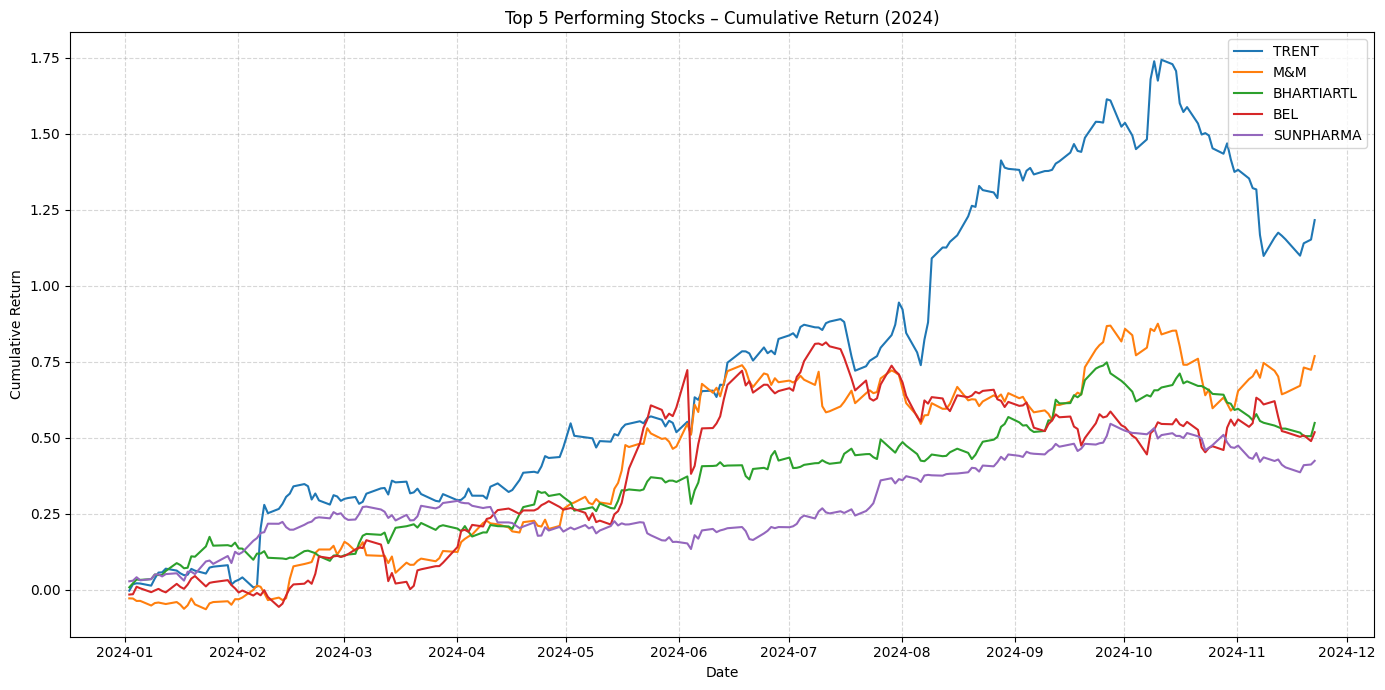

Cumulative return data saved to MySQL and CSV.


In [4]:
#2. Cumulative Return Over Time:
    #Objective: Show the cumulative return of each stock from the beginning of the year to the end.
    #Reason: The cumulative return is an important metric to visualize overall performance and growth over time. This helps users compare how different stocks performed relative to each other.
import os
import yaml
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns
# === MySQL connection ===

import mysql.connector
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='1q2w3e',
    database='ddsa'
)
cursor = conn.cursor()
 
# === Create table===
manual_sql_types = {
    "ticker": "VARCHAR(30)",
    "date": "DATE",
    "month": "VARCHAR(7)",
    "open": "FLOAT",
    "high": "FLOAT",
    "low": "FLOAT",
    "close": "FLOAT",
    "volume": "BIGINT",
    "daily_return": "FLOAT",
    "cumulative_return": "FLOAT",
    "finalcumulativereturn": "FLOAT"

    
}

def clean_column(name):
    return name.strip().lower().replace(" ", "_").replace("-", "_")

def create_and_insert(table_name, df):
    print(f"Inserting into table: {table_name} ({len(df)} rows)")

    # Clean columns
    df.columns = [clean_column(col) for col in df.columns]

    # Convert 'date' column
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'], errors='coerce')

    # Drop existing table
    cursor.execute(f"DROP TABLE IF EXISTS `{table_name}`")

    # Create table SQL
    columns_sql = []
    for col in df.columns:
        col_type = manual_sql_types.get(col, "FLOAT")
        columns_sql.append(f"`{col}` {col_type}")
    create_sql = f"CREATE TABLE `{table_name}` ({', '.join(columns_sql)})"
    cursor.execute(create_sql)

    # Insert data
    for _, row in df.iterrows():
        values = ', '.join(
            f"'{str(val).replace('\'', '\'\'')}'" if pd.notna(val) else "NULL"
            for val in row
        )
        insert_sql = f"INSERT INTO `{table_name}` VALUES ({values})"
        try:
            cursor.execute(insert_sql)
        except Exception as e:
            print(f"Insert failed for row: {row.tolist()} — {e}")

    conn.commit()

# === Cumulative return processing ===
input_folder = "nifty_50_data_csvs"
cumulative_output_folder = "cumulative_return_csv"
os.makedirs(cumulative_output_folder, exist_ok=True)

csv_files = glob.glob(os.path.join(input_folder, "*.csv"))
cumulative_data = []
performance_summary = []

for file in csv_files:
    ticker = os.path.basename(file).replace("_data.csv", "").lower()
    
    try:
        df = pd.read_csv(file)
        df.columns = [clean_column(col) for col in df.columns]

        if 'date' not in df.columns or 'close' not in df.columns:
            print(f"Missing 'date' or 'close' in {file}")
            continue

        df['date'] = pd.to_datetime(df['date'], errors='coerce')
        df = df.dropna(subset=["date"]).sort_values("date")

        # Filter for 2024 only
        df = df[df['date'].dt.year == 2024]
        if df.empty:
            continue

        # Calculate returns
        df["daily_return"] = df["close"].pct_change()
        df["cumulative_return"] = (1 + df["daily_return"]).cumprod() - 1

        # Final return summary
        final_return = df["cumulative_return"].iloc[-1]
        performance_summary.append({"Ticker": ticker.upper(), "FinalCumulativeReturn": final_return})

        # Save to CSV
        output_path = os.path.join(cumulative_output_folder, f"{ticker}_cumulative.csv")
        df.to_csv(output_path, index=False)

        # Save to SQL
        create_and_insert(f"{ticker}_cumulative", df)

        # For plotting
        cumulative_data.append(df[["date", "cumulative_return"]].assign(ticker=ticker.upper()))

    except Exception as e:
        print(f"Error processing {file}: {e}")

# === Summary and plot ===
summary_df = pd.DataFrame(performance_summary).dropna()
top5 = summary_df.sort_values(by="FinalCumulativeReturn", ascending=False).head(5)
top5.to_csv("top5_cumulative_return.csv", index=False)

# Save the top5_cumulative_return to SQL
create_and_insert("top5_cumulative_return", top5)

# Plot top 5 cumulative returns
plt.figure(figsize=(14, 7))
for ticker in top5["ticker"]:
    for df in cumulative_data:
        if df["ticker"].iloc[0] == ticker:
            plt.plot(df["date"], df["cumulative_return"], label=ticker)

plt.title("Top 5 Performing Stocks – Cumulative Return (2024)")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# === Close SQL connection ===
cursor.close()
conn.close()
print("Cumulative return data saved to MySQL and CSV.")

Inserting into table: classified_stocks_by_sector (50 rows)
Inserting into table: stocks_yearly_returns (50 rows)
Inserting into table: sector_wise_performance (20 rows)


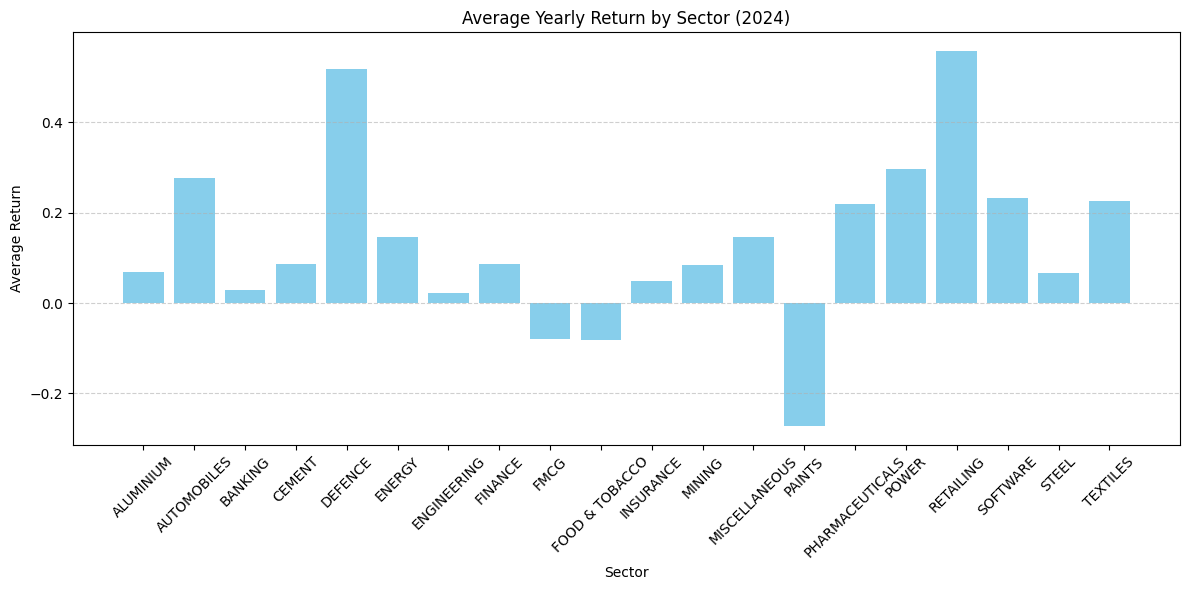

sector_wise_performance data saved to MySQL and CSV.


In [5]:
#3. Sector-wise Performance:
    #Objective: Provide a breakdown of stock performance by sector (sector data shared as csv).
    #Reason: Investors and analysts often look at sector performance to gauge market sentiment in specific industries (e.g., IT, Financials, Energy, etc.).

# === MySQL connection ===
import mysql.connector
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='1q2w3e',
    database='ddsa'
)
cursor = conn.cursor()
 
# === Create table===
manual_sql_types = {
    "ticker": "VARCHAR(30)",
    "date": "DATE",      
    "company": "VARCHAR(100)",
    "month": "VARCHAR(7)", 
    "sector": "VARCHAR(50)",
    "yearlyreturn": "FLOAT",
    "symbol": "VARCHAR(30)",
    "open": "FLOAT",
    "high": "FLOAT",
    "low": "FLOAT",
    "close": "FLOAT",
    "volume": "BIGINT"
    
}

def clean_column(name):
    return name.strip().lower().replace(" ", "_").replace("-", "_")

def create_and_insert(table_name, df):
    print(f"Inserting into table: {table_name} ({len(df)} rows)")

    # Clean columns
    df.columns = [clean_column(col) for col in df.columns]

    # Convert 'date' column
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'], errors='coerce')

    # Drop existing table
    cursor.execute(f"DROP TABLE IF EXISTS {table_name}")

    # Create table SQL
    columns_sql = []
    for col in df.columns:
        col_type = manual_sql_types.get(col, "FLOAT")
        columns_sql.append(f"{col} {col_type}")
    create_sql = f"CREATE TABLE {table_name} ({', '.join(columns_sql)})"
    cursor.execute(create_sql)

    # Insert data
    for _, row in df.iterrows():
        values = ', '.join(
            f"'{str(val).replace('\'', '\'\'')}'" if pd.notna(val) else "NULL"
            for val in row
        )
        insert_sql = f"INSERT INTO {table_name} VALUES ({values})"
        try:
            cursor.execute(insert_sql)
        except Exception as e:
            print(f"Insert failed for row: {row.tolist()} — {e}")

    conn.commit()
#=== sector wise analysing===
# Paths
data_folder = "nifty_50_data_csvs"  #this is a folder path
sector_file = "Sector_data - Sheet1.csv"  # Sector_wise file 

# Collect all CSV files in the data folder
csv_files = glob.glob(os.path.join(data_folder, "*.csv"))

# Load and clean sector mapping
sector_df = pd.read_csv(sector_file)
sector_df.columns = [col.strip().lower() for col in sector_df.columns]

# Extract ticker from 'symbol' column and clean
sector_df['symbol'] = sector_df['symbol'].str.split(":").str[-1].str.strip().str.upper()

# Collect yearly returns
returns = []

for file in csv_files:
    symbol = os.path.basename(file).replace("_data.csv", "").upper()

    try:
        # Load and clean stock data
        df = pd.read_csv(file)
        df.columns = [col.strip().lower() for col in df.columns]

        if "date" not in df.columns or "close" not in df.columns:
            continue

        df["date"] = pd.to_datetime(df["date"], errors="coerce")
        df = df.dropna(subset=["date"]).sort_values("date")

        # Filter data for the year 2024
        df = df[df["date"].dt.year == 2024]
        if df.empty:
            continue

        # Calculate yearly return
        start_price = df["close"].iloc[0]
        end_price = df["close"].iloc[-1]
        yearly_return = (end_price - start_price) / start_price

        # Store the result
        returns.append({"symbol": symbol, "YearlyReturn": yearly_return})

    except Exception as e:
        pass  # Suppress the error message

# Create DataFrame for returns
returns_df = pd.DataFrame(returns)

# Merge returns with sector data (Classify each stock by its sector)
merged_df = pd.merge(returns_df, sector_df, on="symbol", how="left")

# Save the file for classified stocks by their sector
merged_df.to_csv("classified_stocks_by_sector.csv", index=False)

# Save the classified stocks by their sector to SQL
create_and_insert("classified_stocks_by_sector",merged_df )


# Save the file for stocks with their yearly returns
returns_with_sector = merged_df[["symbol", "yearlyreturn", "sector"]]
returns_with_sector.to_csv("stocks_yearly_returns.csv", index=False)

# Save the  stocks with their yearly returns to SQL
create_and_insert("stocks_yearly_returns", returns_with_sector)

# Calculate average yearly return per sector
sector_perf = merged_df.groupby("sector")["yearlyreturn"].mean().reset_index()

# Save the sector performance to a CSV file
sector_perf.to_csv("sector_wise_performance.csv", index=False)

# Save the sector performance to SQL
create_and_insert("sector_wise_performance", sector_perf)

# Plot the sector performance
plt.figure(figsize=(12, 6))
plt.bar(sector_perf["sector"], sector_perf["yearlyreturn"], color='skyblue')
plt.title("Average Yearly Return by Sector (2024)")
plt.ylabel("Average Return")
plt.xlabel("Sector")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# === Close SQL connection ===
cursor.close()
conn.close()
print("sector_wise_performance data saved to MySQL and CSV.")

Inserting into table: stock_daily_pct_change (222 rows)
Inserting into table: stock_correlation_matrix (50 rows)


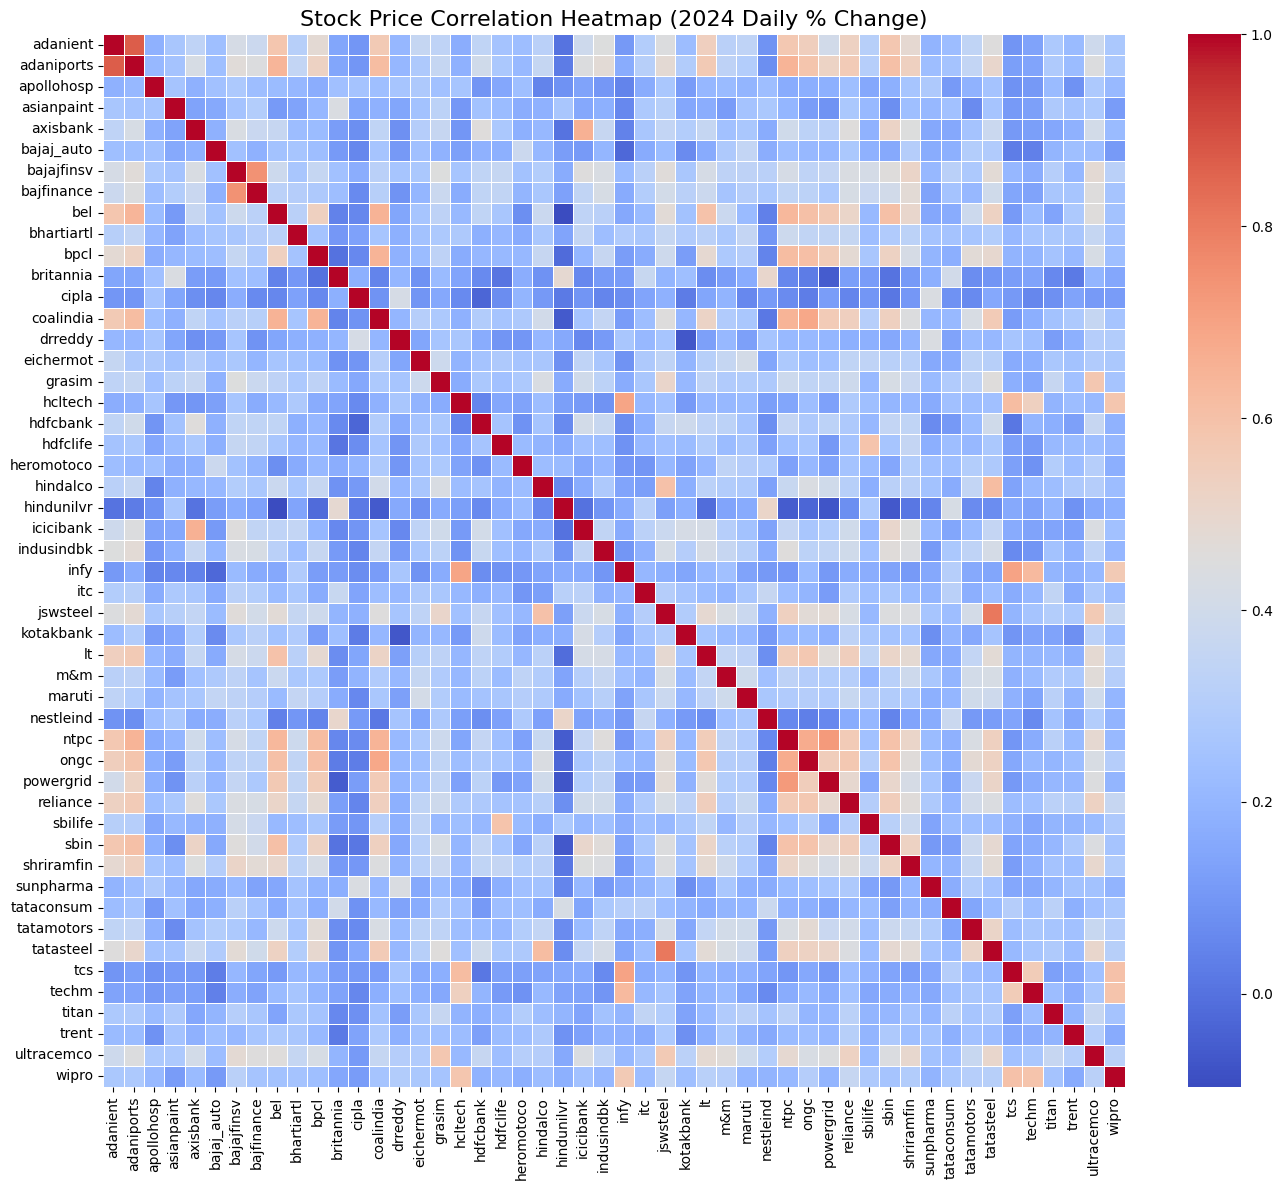

Stock Price Correlation data saved to MySQL and CSV.


In [ ]:
#4. Stock Price Correlation:
    #Objective: Visualize the correlation between the stock prices of different companies.
    #Reason: This analysis is valuable to understand if certain stocks tend to move in tandem (e.g., correlated with market trends or sector performanc

# === MySQL connection ===
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='1q2w3e',
    database='ddsa'
)
cursor = conn.cursor()
 
# === Create table===
manual_sql_types = {
    "ticker": "VARCHAR(30)",
    "date": "DATE",      
    "company": "VARCHAR(100)",
    "month": "VARCHAR(7)", 
    "sector": "VARCHAR(50)",
    "yearlyreturn": "FLOAT",
    "symbol": "VARCHAR(30)",
    "open": "FLOAT",
    "high": "FLOAT",
    "low": "FLOAT",
    "close": "FLOAT",
    "volume": "BIGINT",
    "ADANIENT": "VARCHAR(50)",	
    "ADANIPORTS": "VARCHAR(50)",	
    "APOLLOHOSP": "VARCHAR(50)",	
    "ASIANPAINT": "VARCHAR(50)",	
    "AXISBANK": "VARCHAR(50)",	
    "BAJAJ-AUTO": "VARCHAR(50)",	
    "BAJAJFINSV": "VARCHAR(50)",	
    "BAJFINANCE": "VARCHAR(50)",	
    "BEL": "VARCHAR(50)",
    "BHARTIARTL": "VARCHAR(50)",	
    "BPCL": "VARCHAR(50)",	
    "BRITANNIA": "VARCHAR(50)",	
    "CIPLA": "VARCHAR(50)",	
    "COALINDIA": "VARCHAR(50)",	
    "DRREDDY": "VARCHAR(50)",	
    "EICHERMOT": "VARCHAR(50)",	
    "GRASIM": "VARCHAR(50)",	
    "HCLTECH": "VARCHAR(50)",
    "HDFCBANK": "VARCHAR(50)",
    "HDFCLIFE": "VARCHAR(50)",	
    "HEROMOTOCO": "VARCHAR(50)",	
    "HINDALCO": "VARCHAR(50)",	
    "HINDUNILVR": "VARCHAR(50)",	
    "ICICIBANK": "VARCHAR(50)",	
    "INDUSINDBK": "VARCHAR(50)",	
    "INFY": "VARCHAR(50)",	
    "ITC": "VARCHAR(50)",
    "JSWSTEEL": "VARCHAR(50)",	
    "KOTAKBANK": "VARCHAR(50)",	
    "LT": "VARCHAR(50)",	
    "M&M": "VARCHAR(50)",	
    "MARUTI": "VARCHAR(50)",	
    "NESTLEIND": "VARCHAR(50)",	
    "NTPC": "VARCHAR(50)",	
    "ONGC": "VARCHAR(50)",	
    "POWERGRID": "VARCHAR(50)",	
    "RELIANCE": "VARCHAR(50)",	
    "SBILIFE": "VARCHAR(50)",
    "SBIN": "VARCHAR(50)",	
    "SHRIRAMFIN": "VARCHAR(50)",	
    "SUNPHARMA": "VARCHAR(50)",	
    "TATACONSUM": "VARCHAR(50)",	
    "TATAMOTORS": "VARCHAR(50)",
    "TATASTEEL": "VARCHAR(50)",
    "TCS": "VARCHAR(50)",
    "TECHM": "VARCHAR(50)",
    "TITAN": "VARCHAR(50)",
    "TRENT": "VARCHAR(50)",
    "ULTRACEMCO": "VARCHAR(50)",
    "WIPRO": "VARCHAR(50)"

}

def clean_column(name):
    return name.strip().lower().replace(" ", "_").replace("-", "_")

def create_and_insert(table_name, df):
    print(f"Inserting into table: {table_name} ({len(df)} rows)")

    # Clean columns
    df.columns = [clean_column(col) for col in df.columns]

    # Convert 'date' column
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'], errors='coerce')

    # Drop existing table
    cursor.execute(f"DROP TABLE IF EXISTS `{table_name}`")

    # Create table SQL
    columns_sql = []
    for col in df.columns:
        col_type = manual_sql_types.get(col, "FLOAT")
        columns_sql.append(f"`{col}` {col_type}")
    create_sql = f"CREATE TABLE `{table_name}` ({', '.join(columns_sql)})"
    cursor.execute(create_sql)

    # Insert data
    for _, row in df.iterrows():
        values = ', '.join(
            f"'{str(val).replace('\'', '\'\'')}'" if pd.notna(val) else "NULL"
            for val in row
        )
        insert_sql = f"INSERT INTO `{table_name}` VALUES ({values})"
        try:
            cursor.execute(insert_sql)
        except Exception as e:
            print(f"Insert failed for row: {row.tolist()} — {e}")

    conn.commit()

# === Stock Price Correlation===
import seaborn as sns
# Paths
data_folder = "nifty_50_data_csvs"  # Ensure this is a folder path
csv_files = glob.glob(os.path.join(data_folder, "*.csv"))

# Dictionary to store daily % change
stock_pct_changes = {}

# Load and process each stock file
for file in csv_files:
    symbol = os.path.basename(file).replace("_data.csv", "").upper()

    try:
        df = pd.read_csv(file)
        df.columns = [col.strip().lower() for col in df.columns]

        if "date" not in df.columns or "close" not in df.columns:
            continue

        df["date"] = pd.to_datetime(df["date"], errors="coerce")
        df = df.dropna(subset=["date"]).sort_values("date")

        df = df[df["date"].dt.year == 2024]
        if df.empty:
            continue

        # Calculate daily percentage change
        df.set_index("date", inplace=True)
        df_pct = df["close"].pct_change().dropna()
        stock_pct_changes[symbol] = df_pct

    except Exception:
        pass  # Ignore bad files

# Combine into a single DataFrame
pct_change_df = pd.DataFrame(stock_pct_changes)

# Save daily percentage change
pct_change_df.to_csv("stock_daily_pct_change.csv")

# Save the stock_daily_pct_change to SQL
create_and_insert("stock_daily_pct_change", pct_change_df)

# Compute correlation matrix
correlation_matrix = pct_change_df.corr()

# Save correlation matrix
correlation_matrix.to_csv("stock_correlation_matrix.csv")

# Save the stock_correlation_matrix to SQL
create_and_insert("stock_correlation_matrix", correlation_matrix)

# Plot heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False, linewidths=0.5)
plt.title("Stock Price Correlation Heatmap (2024 Daily % Change)", fontsize=16)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# === Close SQL connection ===
cursor.close()
conn.close()
print("Stock Price Correlation data saved to MySQL and CSV.")

Inserting into table: monthly_returns_all_stocks (550 rows)
Inserting into table: monthly_returns_all_stocks (550 rows)
Inserting into table: monthly_top_5_gainers (55 rows)
Inserting into table: monthly_top_5_losers (55 rows)


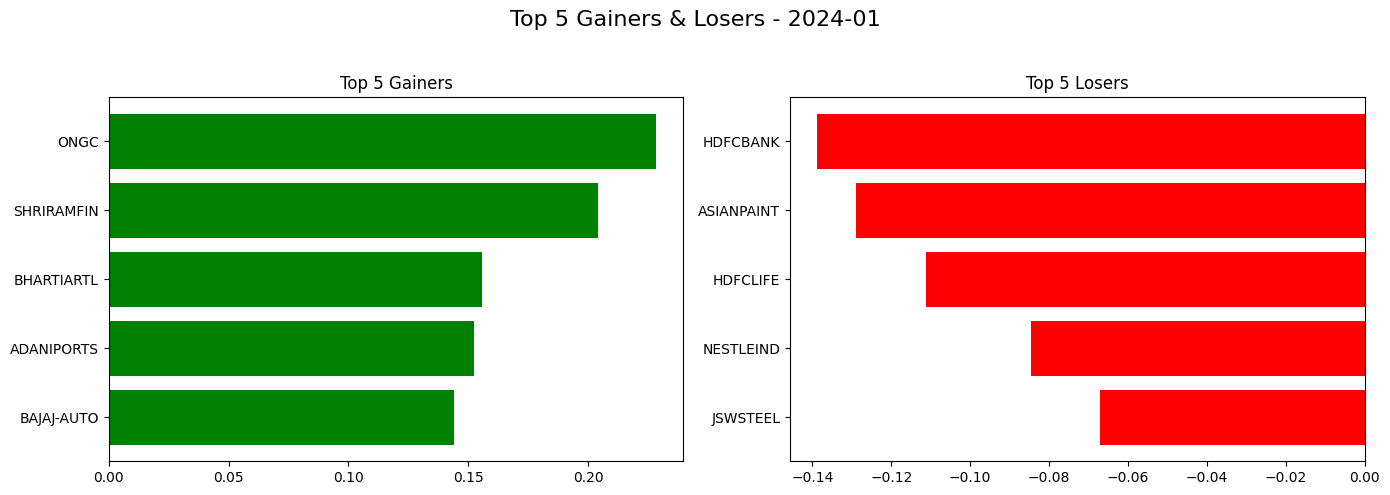

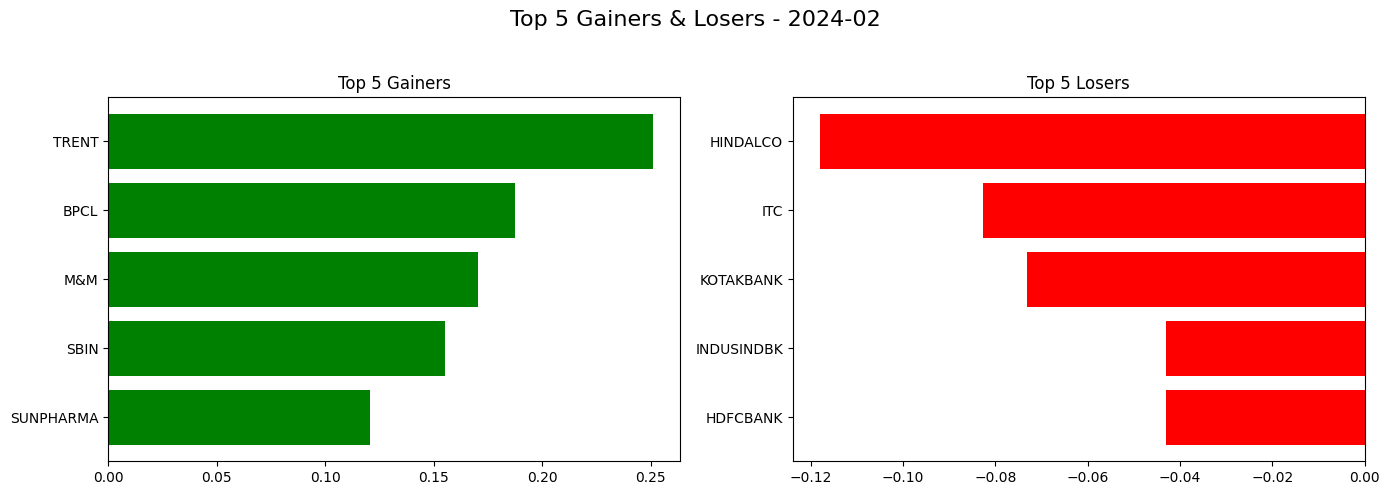

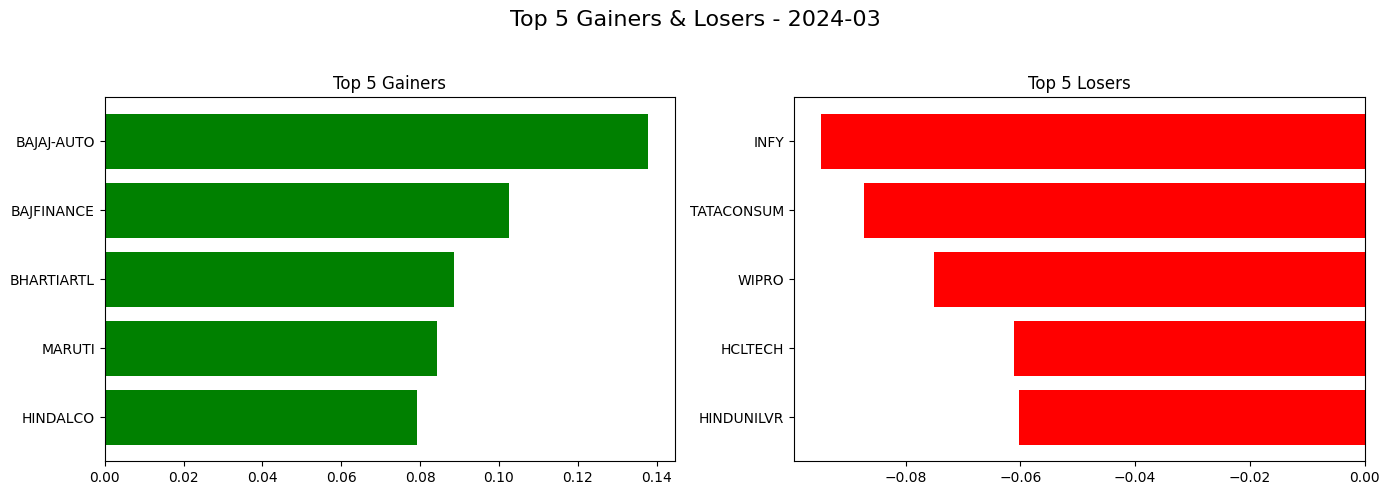

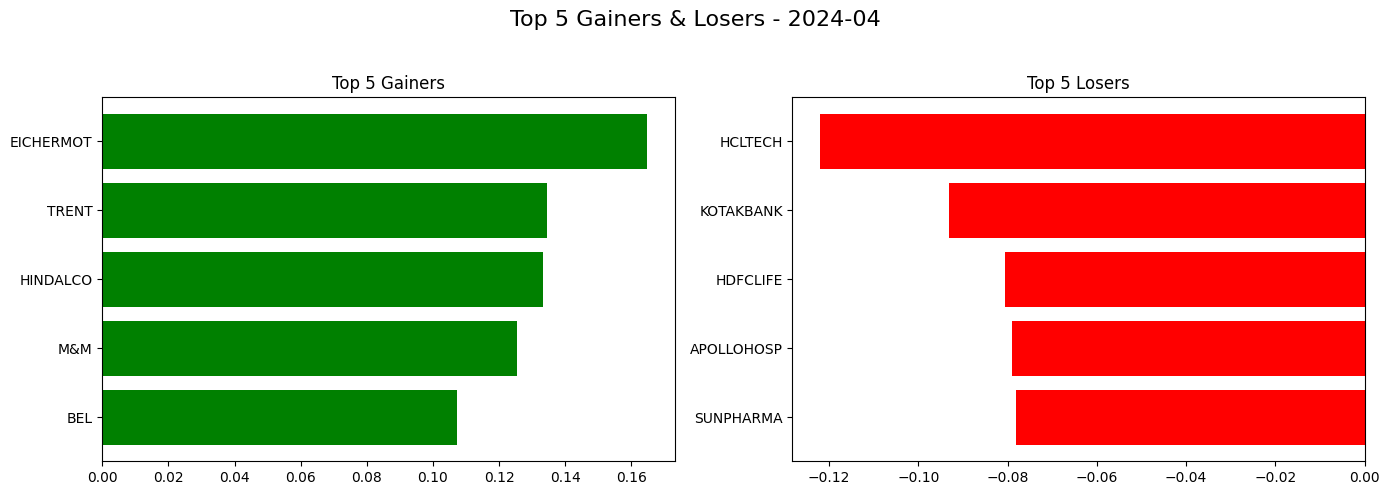

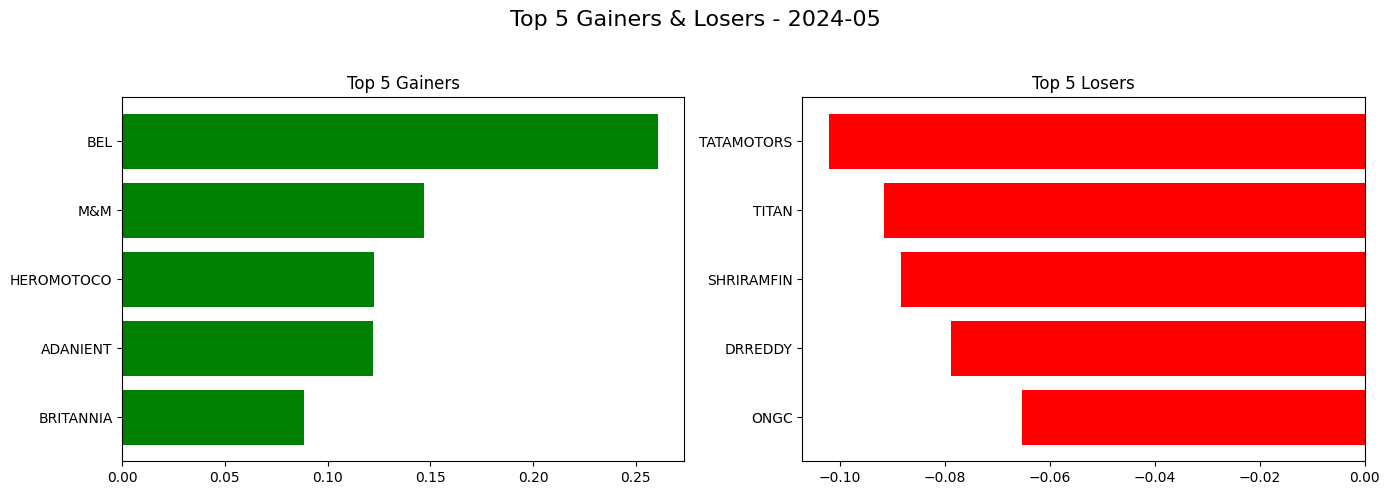

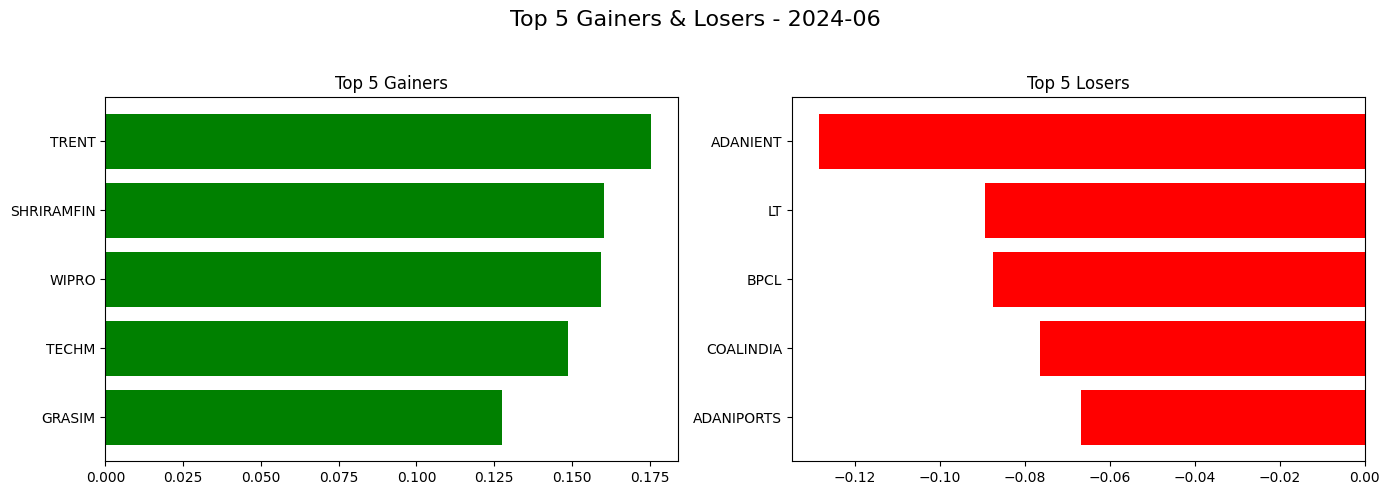

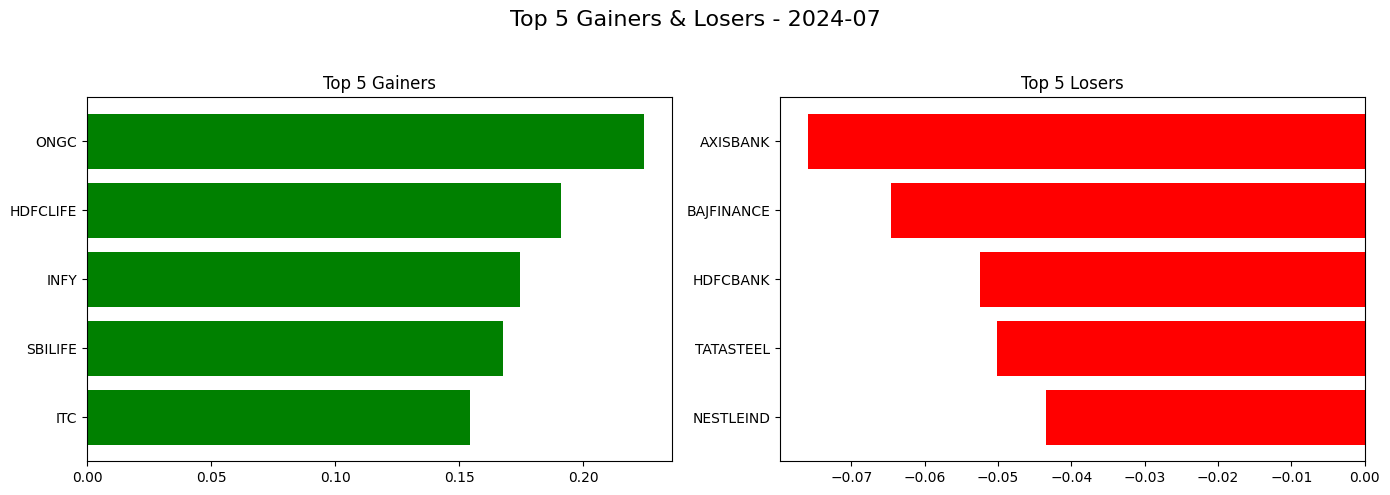

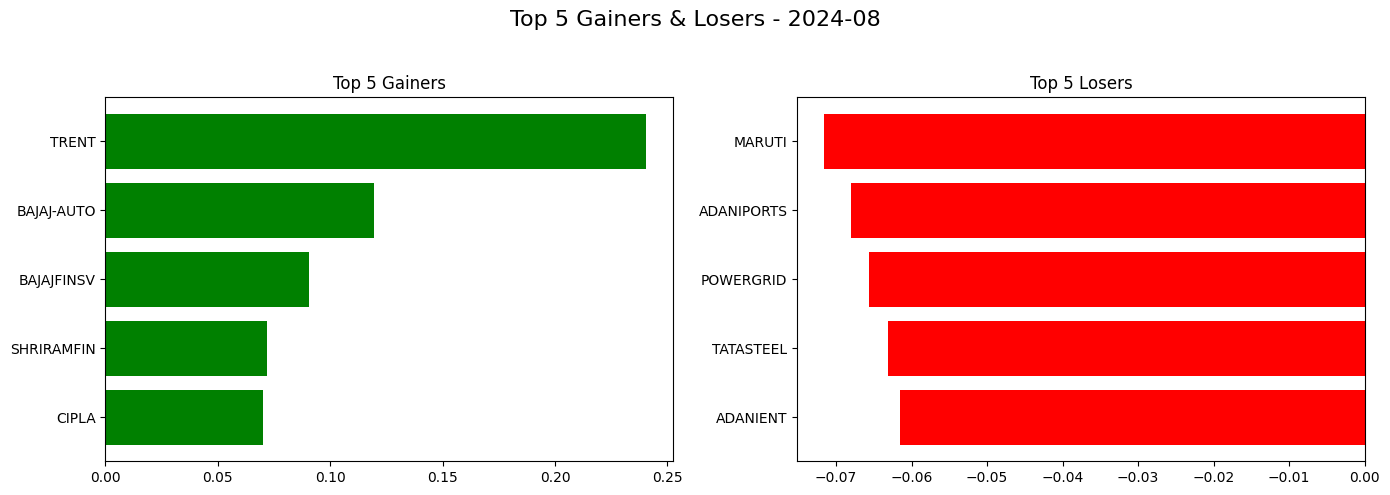

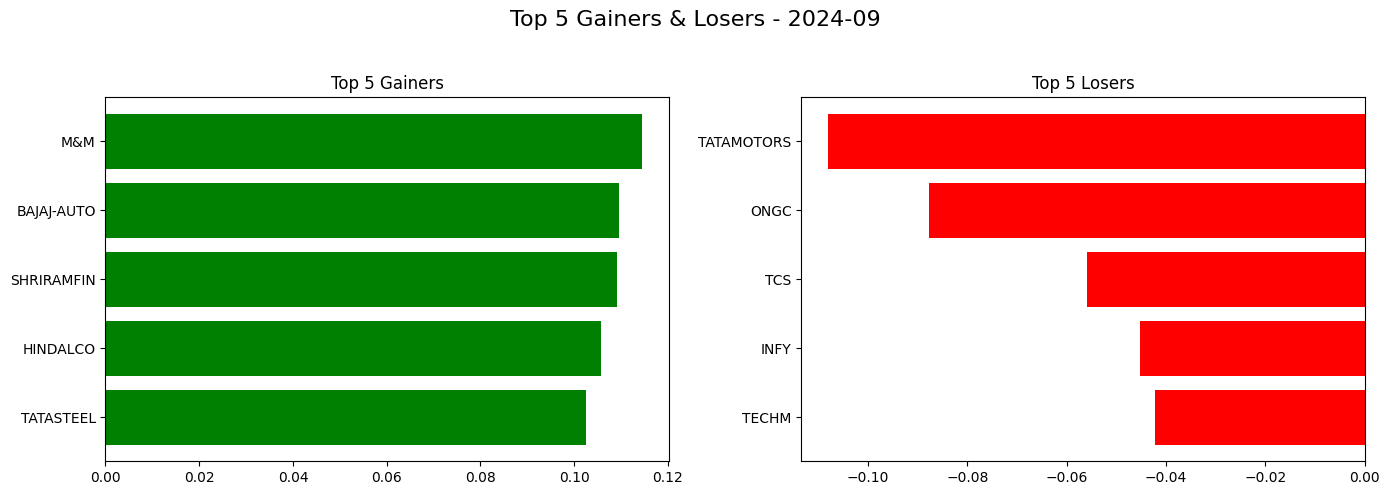

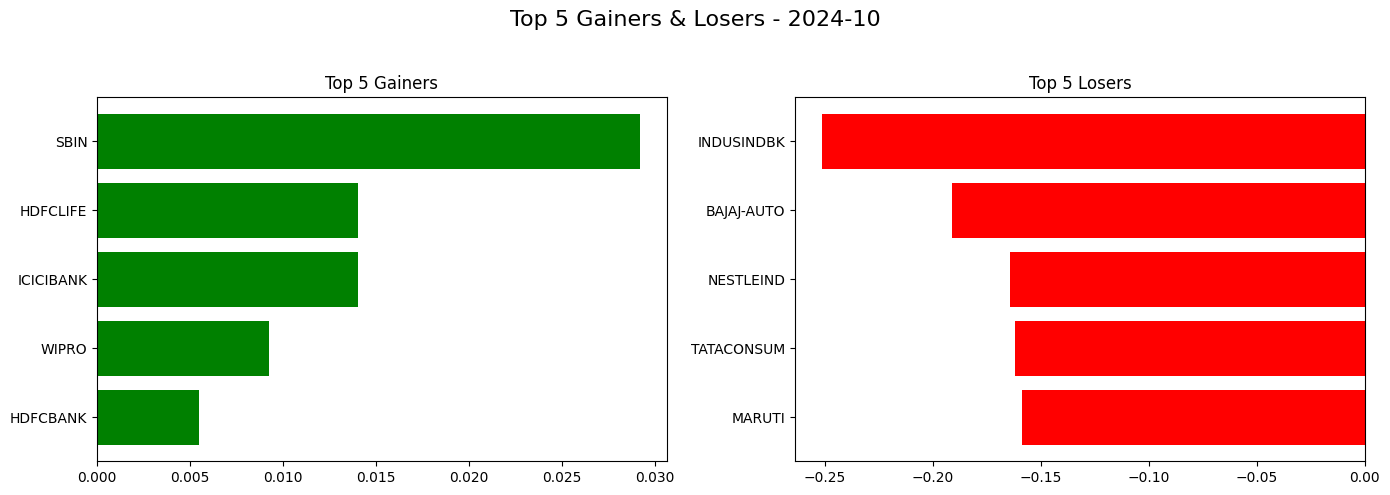

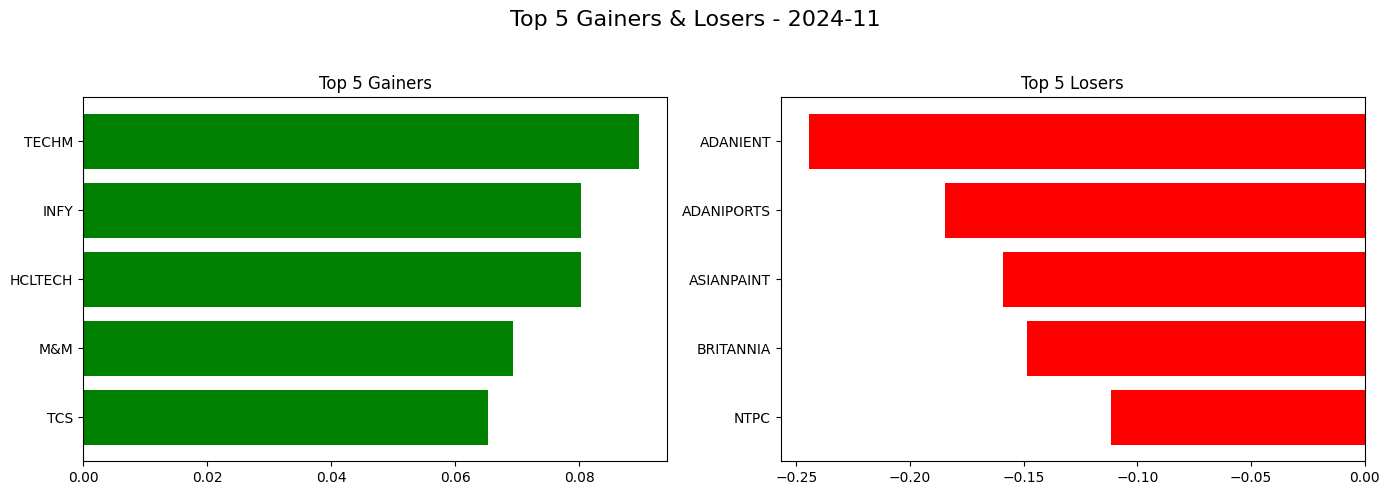

Both files data are saved to MySQL and CSV.


In [ ]:
#5. Top 5 Gainers and Losers (Month-wise):
    #Objective: Provide monthly breakdowns of the top-performing and worst-performing stocks.
    #Reason: This analysis will allow users to observe more granular trends and understand which stocks are gaining or losing momentum on a monthly basis
			
# === MySQL connection ===
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='1q2w3e',
    database='ddsa'
)
cursor = conn.cursor()
 
# === Create table===
manual_sql_types = {
    "ticker": "VARCHAR(30)",
    "symbol":"VARCHAR(30)",
    "date": "DATE",
    "rank":"FLOAT",
    "type":"VARCHAR(10)",
    "month": "VARCHAR(7)",
    "open": "FLOAT",
    "high": "FLOAT",
    "low": "FLOAT",
    "close": "FLOAT",
    "volume": "BIGINT",
    "monthly_return":"FLOAT"
    
}

def clean_column(name):
    return name.strip().lower().replace(" ", "_").replace("-", "_")

def create_and_insert(table_name, df):
    print(f"Inserting into table: {table_name} ({len(df)} rows)")

    # Clean columns
    df.columns = [clean_column(col) for col in df.columns]

    # Convert 'date' column
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'], errors='coerce')

    # Drop existing table
    cursor.execute(f"DROP TABLE IF EXISTS `{table_name}`")

    # Create table SQL
    columns_sql = []
    for col in df.columns:
        col_type = manual_sql_types.get(col, "FLOAT")
        columns_sql.append(f"`{col}` {col_type}")
    create_sql = f"CREATE TABLE `{table_name}` ({', '.join(columns_sql)})"
    cursor.execute(create_sql)

    # Insert data
    for _, row in df.iterrows():
        values = ', '.join(
            f"'{str(val).replace('\'', '\'\'')}'" if pd.notna(val) else "NULL"
            for val in row
        )
        insert_sql = f"INSERT INTO `{table_name}` VALUES ({values})"
        try:
            cursor.execute(insert_sql)
        except Exception as e:
            print(f"Insert failed for row: {row.tolist()} — {e}")

    conn.commit()

# ===Top 5 Gainers and Losers===
# Paths
data_folder = "nifty_50_data_csvs"  # Folder path containing CSV files
csv_files = glob.glob(os.path.join(data_folder, "*.csv"))

monthly_returns = []

# Process each stock file
for file in csv_files:
    symbol = os.path.basename(file).replace("_data.csv", "").upper()

    try:
        df = pd.read_csv(file)
        df.columns = [col.strip().lower() for col in df.columns]

        if "date" not in df.columns or "close" not in df.columns:
            continue

        df["date"] = pd.to_datetime(df["date"], errors="coerce")
        df = df.dropna(subset=["date"])
        df = df[df["date"].dt.year == 2024]

        if df.empty:
            continue

    
        df["month"] = df["date"].dt.to_period("M")
        grouped = df.groupby("month")

        for month, group in grouped:
            group = group.sort_values("date")
            start_price = group["close"].iloc[0]
            end_price = group["close"].iloc[-1]
            monthly_return = (end_price - start_price) / start_price
            monthly_returns.append({
                "symbol": symbol,
                "month": str(month),
                "monthly_return": monthly_return
            })

    except Exception:
        pass  # Skip faulty files

# Create DataFrame
monthly_returns_df = pd.DataFrame(monthly_returns)

# Save all monthly returns
monthly_returns_df.to_csv("monthly_returns_all_stocks.csv", index=False)

# Save the monthly_returns_all_stocks to SQL
create_and_insert("monthly_returns_all_stocks",monthly_returns_df )

# Top 5 Gainers and Losers Per Month
top_gainers = []
top_losers = []

for month in monthly_returns_df["month"].unique():
    month_data = monthly_returns_df[monthly_returns_df["month"] == month]

    # Top 5 gainers
    gainers = month_data.nlargest(5, "monthly_return").copy()
    gainers["rank"] = range(1, 6)
    gainers["type"] = "Gainer"
    top_gainers.append(gainers)

    # Top 5 losers
    losers = month_data.nsmallest(5, "monthly_return").copy()
    losers["rank"] = range(1, 6)
    losers["type"] = "Loser"
    top_losers.append(losers)

# Concatenate and save
top_gainers_df = pd.concat(top_gainers)
top_losers_df = pd.concat(top_losers)

top_gainers_df.to_csv("monthly_top_5_gainers.csv", index=False)
top_losers_df.to_csv("monthly_top_5_losers.csv", index=False)

# Save both the file to SQL
create_and_insert("monthly_top_5_gainers",top_gainers_df )
create_and_insert("monthly_top_5_losers",top_losers_df )

# Dashboard-style plots (12 months)
months = sorted(monthly_returns_df["month"].unique())
for month in months:
    month_gainers = top_gainers_df[top_gainers_df["month"] == month]
    month_losers = top_losers_df[top_losers_df["month"] == month]

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    fig.suptitle(f"Top 5 Gainers & Losers - {month}", fontsize=16)

    axes[0].barh(month_gainers["symbol"], month_gainers["monthly_return"], color='green')
    axes[0].set_title("Top 5 Gainers")
    axes[0].invert_yaxis()

    axes[1].barh(month_losers["symbol"], month_losers["monthly_return"], color='red')
    axes[1].set_title("Top 5 Losers")
    axes[1].invert_yaxis()

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# === Close SQL connection ===
cursor.close()
conn.close()
print("Both files data are saved to MySQL and CSV.")